In [1]:
import wntr
from scripts.valves import ValveStates,create_valvestates
from scripts.segment import *
from scripts.valves import *

In [2]:
class HydroSegmentNet(object):
    def __init__(self,vstates,src_pids):
        self.vstates = vstates
        
        self.segments = simulate_segments(self.vstates)
        self.sid2index = self._init_sid2index()
        self.nid2seg = get_nid2seg_dict(self.segments)
        self.pid2seg = get_pid2seg_dict(self.segments)
        self.src_segments = self._get_src_segments(src_pids)
        self.seg_adj_mtx = self._init_seg_adj_mtx()
    
    def _init_sid2index(self):
        sid2index = {}
        for i, seg in enumerate(self.segments):
            sid2index[seg.sid] = i
        return sid2index
    
    def _init_seg_adj_mtx(self):
        A = np.zeros((len(self.segments),len(self.segments)))
        linking_valves = self.vstates.normal_valves+self.vstates.white_valves
        for v in linking_valves:
            seg0 = self.nid2seg[v.nid]
            seg1 = self.pid2seg[v.pid]
            A[seg0.sid,seg1.sid] = 1
            A[seg1.sid,seg0.sid] = 1 # symmetry
        return A 
    
    def _get_src_segments(self,src_pids):
        src_segments = []
        for src_pid in src_pids:
            src_segments.append(self.pid2seg[src_pid])
        return src_segments

    def _adjust_index_mapping(self,sindex2delete):
        # sid2index 
        for sid,sindex in self.sid2index.items():
            if sindex:
                if sindex > sindex2delete:
                    self.sid2index[sid] -= 1
                elif sindex== sindex2delete:
                    self.sid2index[sid] = None
                    
        # nid/pid mappings
        self.nid2seg = get_nid2seg_dict(self.segments)
        self.pid2seg = get_pid2seg_dict(self.segments)
        
    def _adjust_seg_adj_mtx(self,sindex2delete,sindex2merge):
        self.seg_adj_mtx[sindex2merge,:] += self.seg_adj_mtx[sindex2delete,:]
        self.seg_adj_mtx[:,sindex2merge] += self.seg_adj_mtx[:,sindex2delete]
        
        self.seg_adj_mtx = np.delete(self.seg_adj_mtx,sindex2delete,0)
        self.seg_adj_mtx = np.delete(self.seg_adj_mtx,sindex2delete,1)
        
                
    def _merge_segment(self,seg_from,seg_to):
        seg_to += seg_from 
        
        sindex2delete = self.sid2index[seg_from.sid]
        sindex2merge = self.sid2index[seg_to.sid]
        self.segments.pop(sindex2delete)
        
        self._adjust_seg_adj_mtx(sindex2delete,sindex2merge)
        self._adjust_index_mapping(sindex2delete)
        
        sindex2merge = self.sid2index[seg_to.sid] # index mapping has changed
        return seg_to
        
    def valve_fail(self):
        failed_valve = self.vstates.fail_valves(1)[0]
        seg_from = self.nid2seg[failed_valve.nid]
        seg_to = self.pid2seg[failed_valve.pid]
        if seg_from != seg_to:
            merged_segment = self._merge_segment(seg_from,seg_to)
            
    @property 
    def vfail_rate(self):
        return self.vstates.fail_rate
    
    @property
    def valid_pipe_segments(self):
        valid_segments = []
        for seg in self.segments:
            if seg not in self.src_segments:
                if len(seg.pids) > 0:
                    valid_segments.append(seg)
        return valid_segments
        
        
        
        
def get_nid2seg_dict(segments):
    nid2seg = {}
    for seg in segments:
        for nid in seg.nids:
            nid2seg[nid] = seg
    return nid2seg

def get_pid2seg_dict(segments):
    pid2seg = {}
    for seg in segments:
        for pid in seg.pids:
            pid2seg[pid] = seg
    return pid2seg
        
            
            

In [3]:
def get_valid_segments(segnet,src_nids):
    valid_segs = []
    for segment in segnet.segments:
        if src_nid not in segment.nids:
            if len(segment.pids) > 0:
                valid_segs.append(segment)
    return valid_segs
    
def get_segment_pnames(valid_segs):
    segment_pnames = []
    for segment in valid_segs:
        pids = segment.pids
        pnames = [lid2lname[pid] for pid in pids]
        segment_pnames.append(pnames)
    return segment_pnames

def get_segment_nnames(valid_segs):
    segment_nnames = []
    for segment in valid_segs:
        nids = segment.nids
        nnames = [nid2nname[nid] for nid in nids]
        segment_nnames.append(nnames)
    return segment_nnames
    

In [4]:
import os
import glob 
import multiprocessing as mp
import copy


def close_pipes(pipe_names,wn):
    for pipe_name in pipe_names:
        pipe = wn.get_link(pipe_name)        
        pipe.status = wntr.network.LinkStatus.Closed
    return wn

def open_pipes(pipe_names,wn):
    for pipe_name in pipe_names:
        pipe = wn.get_link(pipe_name)        
        pipe.status = wntr.network.LinkStatus.Open
    return wn

def remove_demand(node_names,wn):
    demands = []
    for node_name in node_names:
        demand = copy.deepcopy(wn.get_node(node_name).demand_timeseries_list[0].base_value)
        demands.append(demand)
        wn.get_node(node_name).demand_timeseries_list[0].base_value = 0
    return demands,wn

def restore_demand(node_names,demands,wn):
    for node_name,demand in zip(node_names,demands):
        wn.get_node(node_name).demand_timeseries_list[0].base_value = demand
    return wn
    
def isolate_pipes(pipe_names,node_names,wn):
    wn = copy.deepcopy(wn)
    wn = close_pipes(pipe_names,wn)
    demands, wn = remove_demand(node_names,wn)
    sim = wntr.sim.EpanetSimulator(wn)
    
    np.random.seed()
    rand_name = './temp/'+str(np.random.randint(1e9))
    try:
        results = sim.run_sim(file_prefix=rand_name)
    except:
        print ('Issues when running hydrualic simulation, use the initial result')
        results = init_result
    wn = open_pipes(pipe_names,wn)
    wn = restore_demand(node_names,demands,wn)
    return results

def remove_temps():
    temp_files = glob.glob("./temp/*")
    for file in temp_files:
        os.remove(file)
        
def hydrau_segments_sim(valid_segments):
    segment_pnames = get_segment_pnames(valid_segments)
    segment_nnames = get_segment_nnames(valid_segments)
    pool = mp.Pool(mp.cpu_count()-1)
    results = pool.starmap(isolate_pipes, [(pipe_name,node_name,wn) for pipe_name,node_name 
                                           in zip(segment_pnames,segment_nnames)])
    pool.close()
    remove_temps()
    return results
    
    
def find_direct_loses(valid_segments,init_demand):
    direct_loses = []
    for segment in valid_segments:
        direct_lose = []
        for nid in segment.nids:
            nname = nid2nname[nid]
            demand = init_demand[nname].to_numpy()[0]
            direct_lose.append ((nname,max(demand,0)))
        direct_loses.append(direct_lose)
    return direct_loses
        

In [5]:
def analyze_drop_ratio(dvals,init_vals,keys,thre = -0.1):
    drop_cond = dvals < thre
    drop_ratio = abs(dvals[drop_cond]/init_vals[drop_cond])*100
    impacted_keys = keys[drop_cond]
    drops = [(key,drop) for key, drop in zip(impacted_keys,drop_ratio)]
    return drops

def analyze_drop(dvals,init_vals,keys,thre = -0.1):
    drop_cond = dvals < thre
    drops = abs(dvals[drop_cond])
    impacted_keys = keys[drop_cond]
    drops = [(key,drop) for key, drop in zip(impacted_keys,drops)]
    return drops

def find_hydrau_loses(init_result,hydrau_results):
    init_pressure = init_result.node['pressure'].to_numpy().flatten()
    init_demand = init_result.node['demand'].to_numpy().flatten()
    keys = init_result.node['pressure'].keys().to_numpy().flatten()
    pressure_loses,demand_loses = [],[]
    
    for res in hydrau_results:
        pressure = res.node['pressure'].to_numpy().flatten()
        demand = res.node['demand'].to_numpy().flatten()
        pressure = [p if p >0 else 0 for p in pressure]
        demand = [d if d >0 else 0 for d in demand]
        dp = pressure-init_pressure
        pressure_drop = analyze_drop(dp,init_pressure,keys)
        pressure_loses.append(pressure_drop)

        dd = demand-init_demand
        demand_drop = analyze_drop(dd,init_demand,keys,-1e-6)
        demand_loses.append(demand_drop)
    return pressure_loses,demand_loses

def fail_valves(segnet,fail_rate):
    num_valves = len(segnet.vstates.valid_valves)
    nv2fail = int(num_valves*fail_rate)
    for i in range (nv2fail):
        segnet.valve_fail()
    return segnet
    
    
    

In [6]:
def summarize_loses(loses):
    tot_lose = []
    for lose in loses:
        lose_sum = 0
        if len(lose):
            for k,l in lose:
                lose_sum+=l
        tot_lose.append(lose_sum)
    return tot_lose

def init_costs(wn):
    pname2pcost = {}
    pname2dcost = {}
    for pipe_name in wn.pipe_name_list:
        pname2pcost[pipe_name] = 0
        pname2dcost[pipe_name] = 0
    return pname2pcost,pname2dcost
    
    
def update_cost(pressure_costs,demand_costs,valid_segments,
               pname2pcost,pname2dcost):
    for i in range(len(valid_segments)):
        segment = valid_segments[i]
        pressure_cost = pressure_costs[i]
        demand_cost = demand_costs[i]
        for pid in segment.pids:
            pname = lid2lname[pid]
            pname2pcost[pname] += pressure_cost
            pname2dcost[pname] += demand_cost
    return pname2pcost,pname2dcost


In [7]:
# def cost_analysis(wn,vfail_rate,segnet):
#     segnet = copy.deepcopy(segnet)
#     segnet = fail_valves(segnet,vfail_rate)
    
#     sim = wntr.sim.EpanetSimulator(wn)
#     rand_name = './temp/'+str(np.random.randint(1e6))
#     init_result = sim.run_sim(file_prefix=rand_name)
#     pname2pcost,pname2dcost = init_costs(wn)
    
#     valid_segments = segnet.valid_pipe_segments
#     init_demand = init_result.node['demand']
#     direct_loses = find_direct_loses(valid_segments,init_demand)
#     hydrau_results = hydrau_segments_sim(valid_segments)
#     pressure_loses,demand_loses = find_hydrau_loses(init_result,hydrau_results)
#     pressure_costs,demand_costs = summarize_loses(pressure_loses),summarize_loses(demand_loses)
    
#     pname2pcost,pname2dcost = update_cost(pressure_costs,demand_costs,
#                                           valid_segments,pname2pcost,pname2dcost)
#     return pname2pcost,pname2dcost
    
    
# def average_cost(cost,num_sim):
#     avg_cost = {}
#     for k,item in cost.items():
#         item = item/num_sim
#         avg_cost[k] = item
#     return avg_cost

# def mc_cost(wn,vfail_rate,segnet,num_sim):
#     tot_pcost,tot_dcost = init_costs(wn)
#     for i in range(num_sim):
#         pname2pcost,pname2dcost = cost_analysis(wn,vfail_rate,segnet)  
#         for pname in wn.pipe_name_list:
#             tot_pcost[pname] += pname2pcost[pname]
#             tot_dcost[pname] += pname2dcost[pname]
#     avg_pcost = average_cost(tot_pcost,num_sim)
#     avg_dcost = average_cost(tot_dcost,num_sim)
    
#     return pname2pcost,pname2dcost
    

In [8]:
# def get_isolations_impact(valid_segments,sim_results,init_result,mode):
#     assert(mode in ['demand','pressure'])
#     impacts = []
#     for segment,sim_result in zip(valid_segments,sim_results):
#         impact = find_isolation_impact(segment,init_result,sim_result,mode)
#         impacts.append(impact)
#     return impacts

# def find_isolation_impact(segment,init_result,sim_result, mode, thre = 1):
#     lose = {}
#     nids = segment.nids

#     init_val = init_result.node[mode].to_numpy().flatten()
#     sim_val = sim_result.node[mode].to_numpy().flatten()
#     lose['direct_loss'] = sum(init_val[nids])
    
#     val_diff = abs(init_val-sim_val)
#     val_diff[nids] = 0  
#     val_diff_ratio = val_diff/init_val*100
#     valid_drop = val_diff_ratio[val_diff_ratio>thre]
#     lose['undirect_loss'] = sum(valid_drop)
#     lose['num_impacted_nodes'] = len(valid_drop)
#     return lose


# def impact_analysis(wn,vfail_rate,segnet):
#     segnet = copy.deepcopy(segnet)
#     segnet = fail_valves(segnet,vfail_rate)
    
#     assert(wn.options.hydraulic.demand_model=='PDA')
#     sim = wntr.sim.EpanetSimulator(wn)
#     rand_name = './temp/'+str(np.random.randint(1e6))
#     init_result = sim.run_sim(file_prefix=rand_name)

    
#     valid_segments = segnet.valid_pipe_segments
#     hydrau_results = hydrau_segments_sim(valid_segments)
#     demand_impacts = get_isolations_impact(valid_segments,hydrau_results,
#                                            init_result,mode = 'demand')
#     pressure_impacts = get_isolations_impact(valid_segments,hydrau_results,
#                                        init_result,mode = 'pressure')

#     return demand_impacts,pressure_impacts


    

/home/rewu/Documents/research/valves/wntr/epanet/io.py:2173: UserWarning: Not all curves were used in "./data/alameda.inp"; added with type None, units conversion left to user
  warnings.warn('Not all curves were used in "{}"; added with type None, units conversion left to user'.format(self.wn.name))
/home/rewu/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


(<matplotlib.collections.PathCollection at 0x7f6ee93394a8>,
 <matplotlib.collections.LineCollection at 0x7f6ee9339358>)

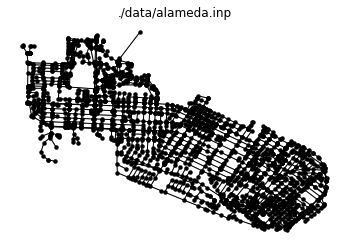

In [9]:
# Create a water network model
inp_file = './data/alameda.inp'
wn = wntr.network.WaterNetworkModel(inp_file)
wn.options.hydraulic.demand_model = 'PDD'
wn.options.hydraulic.minimum_pressure = 3.5
wn.options.hydraulic.required_pressure = 21

wntr.graphics.plot_network(wn, title=wn.name)

In [14]:

# sim = wntr.sim.EpanetSimulator(wn)
# rand_name = './temp/'+str(np.random.randint(1e6))
# init_result = sim.run_sim(file_prefix=rand_name)

In [15]:
# idx = 1
# valid_segments = segnet.valid_pipe_segments
# segment_pnames = get_segment_pnames(valid_segments)
# segment_nnames = get_segment_nnames(valid_segments)

# wn = close_pipes(segment_pnames[idx],wn)
# demands, wn = remove_demand(segment_nnames[idx],wn)
    
# sim = wntr.sim.EpanetSimulator(wn)
# res1 = sim.run_sim()
# impact_analysis

In [31]:
import math
import scipy

def asemble_adj_pids(pids):
    rows = []
    cols = []
    vals = []
    
    for i in range(len(pids)):
        for j in range(i+1,len(pids)):
            rows.append(pids[i])
            cols.append(pids[j])
            vals.append(1)
            
            rows.append(pids[j])
            cols.append(pids[i])
            vals.append(1)
    return rows,cols,vals
            
            
    
def assemble_pipe_adj_mtx(nid2lid):
    rows = []
    cols = []
    vals = []
    for nid, pids in nid2lid.items():
        r,c,v = asemble_adj_pids(pids)
        if len(r):
            assert(len(r) == math.factorial(len(pids))/math.factorial(len(pids)-2))
        rows+=r
        cols+=c
        vals+=v
    pipe_adj_mtx = scipy.sparse.csr_matrix((vals, (rows, cols)))
    return pipe_adj_mtx

        
def get_neighbor_pids(search_pid,required_num,black_list = []):
    if required_num ==0:
        return []
    raw_neighbor_pids =  pipe_adj_mtx.getrow(search_pid).nonzero()[1]
    count = 0
    neighbor_pids = []
   
    for pid in raw_neighbor_pids:
        if pid not in black_list:
            neighbor_pids.append(pid)
            count += 1
            if count == required_num:
                return neighbor_pids
            
    if not count:
#         print (search_pid)
        return neighbor_pids
    
    black_list+= neighbor_pids
    remained_num = required_num-count
    i = 0
    while (remained_num > 0 and i < len(neighbor_pids)):
#         print (search_pid,neighbor_pids,remained_num)
        other_pids = get_neighbor_pids(neighbor_pids[i],remained_num,black_list)
        neighbor_pids += other_pids
        black_list += other_pids
        
        remained_num = required_num-len(neighbor_pids)
        i += 1
    return neighbor_pids

def extract_nids(pids):
    nids = []
    for pid in pids:
        nid1,nid2 = lid2nids[pid]
        nids.append(nid1)
        nids.append(nid2)
    return nids
        
def get_bundles(pids,required_num,source_pids):
    pipe_bundles,node_bundles = [],[]
    neighber_num = required_num-1
    
    for pid in pids:
        pids_cluster = get_neighbor_pids(pid,neighber_num,black_list = [])+[pid]
        nids_cluster = extract_nids(pids_cluster)
        if not set(pids_cluster).intersection(set(source_pids)):       
            pnames_cluster = [lid2lname[pid] for pid in pids_cluster]
            nnames_cluster = [nid2nname[nid] for nid in nids_cluster]
            pipe_bundles.append(pnames_cluster)
            node_bundles.append(nnames_cluster)
    return pipe_bundles,node_bundles
    
    
    

In [32]:
def get_isolations_impact(node_bundles,sim_results,init_result,mode):
    assert(mode in ['demand','pressure'])
    impacts = []
    for node_bundle,sim_result in zip(node_bundles,sim_results):
        impact = find_isolation_impact(node_bundle,init_result,sim_result,mode)
        impacts.append(impact)
    return impacts

def find_isolation_impact(node_bundle,init_result,sim_result, mode, thre = 1):
    lose = {}
    nids = [nname2nid[nname] for nname in node_bundle]

    init_val = init_result.node[mode].to_numpy().flatten()
    sim_val = sim_result.node[mode].to_numpy().flatten()
    lose['direct_loss'] = sum(init_val[nids])
    
    val_diff = abs(init_val-sim_val)
    val_diff[nids] = 0  
    val_diff_ratio = val_diff/init_val*100
    valid_drop = val_diff_ratio[val_diff_ratio>thre]
    lose['undirect_loss'] = sum(valid_drop)
    lose['num_impacted_nodes'] = len(valid_drop)
    return lose

def bundle_hyrau_sims(pipe_bundles,node_bundles):
    pool = mp.Pool(mp.cpu_count()-1)
    results = pool.starmap(isolate_pipes, [(pipe_name,node_name,wn) for pipe_name,node_name 
                                           in zip(pipe_bundles,node_bundles)])
    pool.close()
    pool.join()
    remove_temps()
    return results


def bundle_analysis(wn,pipe_bundles,node_bundles):
    assert(wn.options.hydraulic.demand_model=='PDA')
    sim = wntr.sim.EpanetSimulator(wn)
    rand_name = './temp/'+str(np.random.randint(1e6))
    init_result = sim.run_sim(file_prefix=rand_name)
    
    hydrau_results = bundle_hyrau_sims(pipe_bundles,node_bundles)
    
    demand_impacts = get_isolations_impact(node_bundles,hydrau_results,
                                           init_result,mode = 'demand')
    pressure_impacts = get_isolations_impact(node_bundles,hydrau_results,
                                       init_result,mode = 'pressure')

    return demand_impacts,pressure_impacts
    
    

In [25]:
nname2nid = {}
nid2nname = {}
nid2lid = {}

for nid,nname in enumerate(wn.node_name_list):
    nname2nid[nname] = nid
    nid2nname[nid] = nname
    nid2lid[nid] = []
    
lid2nids = {}
lname2lid = {}
lid2lname = {}


for lid,pipe_name in enumerate(wn.pipe_name_list):
    pipe = wn.get_link(pipe_name)
    n1_name = pipe.start_node_name
    n2_name = pipe.end_node_name
    lname2lid[pipe.name] = lid
    lid2lname[lid] = pipe.name
    
    nid1,nid2 = nname2nid[n1_name],nname2nid[n2_name]
    lid2nids[lid] = (nid1,nid2)
    
    nid2lid[nid1].append(lid)
    nid2lid[nid2].append(lid)
    
pids = lid2lname.keys()
src_pids = [3016]
pipe_adj_mtx = assemble_pipe_adj_mtx(nid2lid)

In [ ]:
required_numbers = [1,3,5,7,9,11,13,15]
demand_impacts,pressure_impacts = [], []

for required_number in required_numbers:
    pipe_bundles,node_bundles = get_bundles(pids,required_number,src_pids)
    demand_impact, pressure_impact = bundle_analysis(wn,pipe_bundles,node_bundles)
    
    demand_impacts.append(demand_impact)
    pressure_impacts.append(pressure_impact)

/home/rewu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/home/rewu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater


In [39]:
p,n = get_bundles(pids,2,src_pids)

In [20]:
demand_impact

[{'direct_loss': 0.0005981689901091158,
  'undirect_loss': 0,
  'num_impacted_nodes': 0},
 {'direct_loss': 0.0005981690283078933,
  'undirect_loss': 399.8075256347656,
  'num_impacted_nodes': 4},
 {'direct_loss': 0.0011795721966336714,
  'undirect_loss': 499.90184783935547,
  'num_impacted_nodes': 5},
 {'direct_loss': 0.0005794763437734218,
  'undirect_loss': 0,
  'num_impacted_nodes': 0},
 {'direct_loss': 0.0005981690283078933,
  'undirect_loss': 399.8075256347656,
  'num_impacted_nodes': 4},
 {'direct_loss': 0.000579476209168206,
  'undirect_loss': 99.71026611328125,
  'num_impacted_nodes': 1},
 {'direct_loss': 0.001179572194814682,
  'undirect_loss': 499.90184783935547,
  'num_impacted_nodes': 5},
 {'direct_loss': 0.0011795721984526608,
  'undirect_loss': 499.90184783935547,
  'num_impacted_nodes': 5},
 {'direct_loss': 0.000598169053773745,
  'undirect_loss': 0,
  'num_impacted_nodes': 0},
 {'direct_loss': 0.0005981690392218297,
  'undirect_loss': 299.1097640991211,
  'num_impacted_

In [21]:
def get_impact_number(impacts):
    num = []
    for imp in impacts:
        num.append(imp['num_impacted_nodes'])
    return np.array(num)
        
demand_impact_num = get_impact_number(demand_impact)
pressure_impact_num = get_impact_number(pressure_impact)

In [22]:
idx = 0
ids = np.array(range(len(demand_impact_num)))

demand_impact_ids = ids[(demand_impact_num>0)]
pressure_impact_ids = ids[(pressure_impact_num>0)]

demand_impact_number = demand_impact_num[demand_impact_ids]
pressure_impact_number = pressure_impact_num[pressure_impact_ids]
len(pressure_impact_ids),len(demand_impact_ids)

# for d,p in zip(demand_impact,pressure_impact):
#     if d['num_impacted_nodes'] > 0:
#         demand_impact_ids.append(idx)
        
#     if p['num_impacted_nodes'] > 0:
#         pressure_impact_ids.append(idx)
#     idx += 1

(900, 681)

In [23]:
# def get_important_pnames(pipe_bundles,important_pids):
#     important_pipes = []
#     for idx in important_pids:
#         pnames = pipe_bundles[idx]
#         important_pipes+=pnames
#     return important_pipes
        

In [24]:
pressure_important_pipes = [lid2lname[pid] for pid in pressure_impact_ids]
demand_important_pipes = [lid2lname[pid] for pid in demand_impact_ids]

In [25]:
from shapely.geometry import Point, LineString
import pandas as pd
import geopandas as gpd
import networkx as nx


def get_pipe_df(wn):
    G = wn.get_graph()
    pos = nx.get_node_attributes(G,'pos')

    lines = []
    pcost_list = []
    dcost_list = []
    for pipe_name in wn.pipe_name_list:
        pipe = wn.get_link(pipe_name)  
        start_node = pipe.start_node_name
        end_node = pipe.end_node_name

        loc_start = pos[start_node]
        loc_end = pos[end_node]
        l = LineString([Point(loc_start), Point(loc_end)])
        lines.append(l)
        
    df_dict = {'pipe_names':wn.pipe_name_list,
              'geometry':lines}
    df = pd.DataFrame.from_dict(df_dict)
    gdf = gpd.GeoDataFrame(df, geometry='geometry')
    return gdf



In [26]:
pipe_data = get_pipe_df(wn)
# tot_demand = init_result.node['demand'].to_numpy().flatten()[:-1].sum()

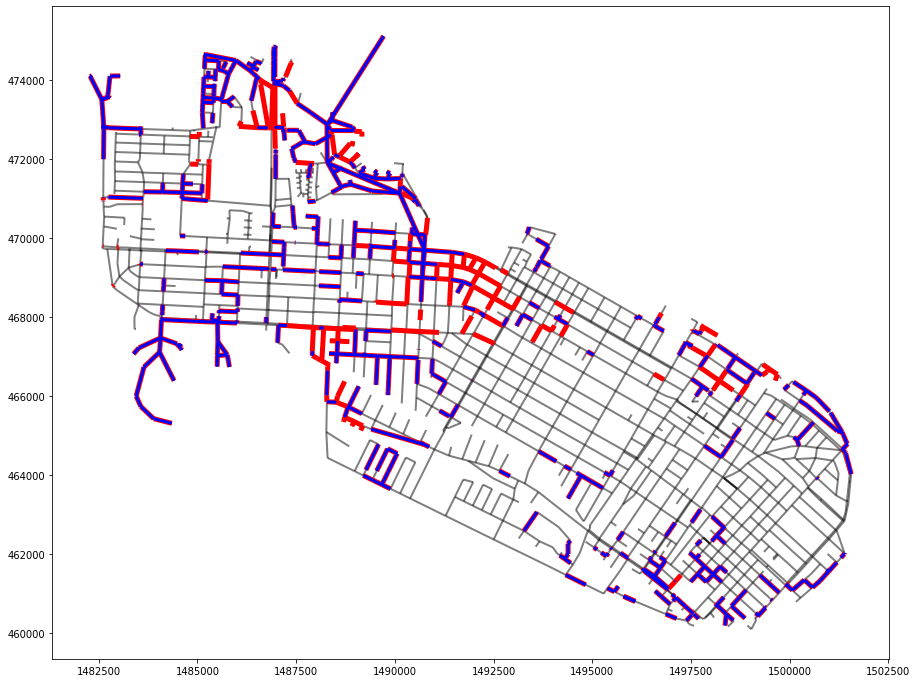

In [27]:
def plot_important_pipes():
    base = pipe_data
    pressure = pipe_data[pipe_data['pipe_names'].isin(pressure_important_pipes)]
    demand = pipe_data[pipe_data['pipe_names'].isin(demand_important_pipes)]

    ax = base.plot(figsize = (20,12),
                         linewidth=2,
                        color = 'black',
                        alpha = 0.5)

    ax = pressure.plot(ax= ax,
#                          column='dcost',
                        color = 'red',
                        linewidth=5,
                        alpha = 1,
                     legend=True)
    
    ax = demand.plot(ax= ax,
#                          column='dcost',
                    color = 'blue',
                    linewidth=3,
                    alpha = 1,
                 legend=True)
    
    
#     vfail_rate = fail_rates[i]
#     title = f'''Demand Cost for Valve Failure Rate {round(vfail_rate, 2)} '''
#     hig_ax.set_title(title, fontsize=25)
    ax.plot()
    
plot_important_pipes()

In [27]:
pressure = pipe_data[pipe_data['pipe_names'].isin(pressure_important_pipes)]
pressure['impact_number'] = pressure_impact_number

/home/rewu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


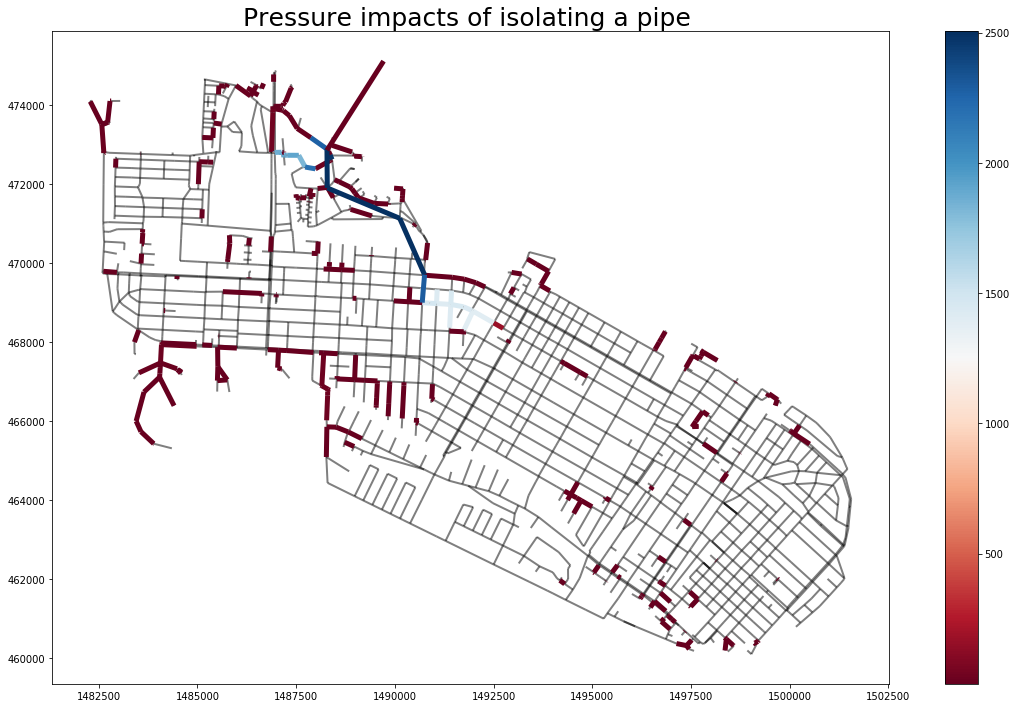

In [28]:
def plot_pressure_impacts():
    base = pipe_data
    
    pressure = pipe_data[pipe_data['pipe_names'].isin(pressure_important_pipes)]
    pressure = pressure.set_index('pipe_names')
    ser = pd.Series(pressure_impact_number, index =pressure_important_pipes) 
    pressure['impact_number'] = ser


    ax = base.plot(figsize = (20,12),
                         linewidth=2,
                        color = 'black',
                        alpha = 0.5)

    ax = pressure.plot(ax= ax,
                         column='impact_number',
                        cmap = 'RdBu',
                        linewidth=5,
                        alpha = 1,
                     legend=True)
    
#     vfail_rate = fail_rates[i]
    title = f'''Pressure impacts of isolating a pipe '''
    ax.set_title(title, fontsize=25)
    ax.plot()
    
plot_pressure_impacts()

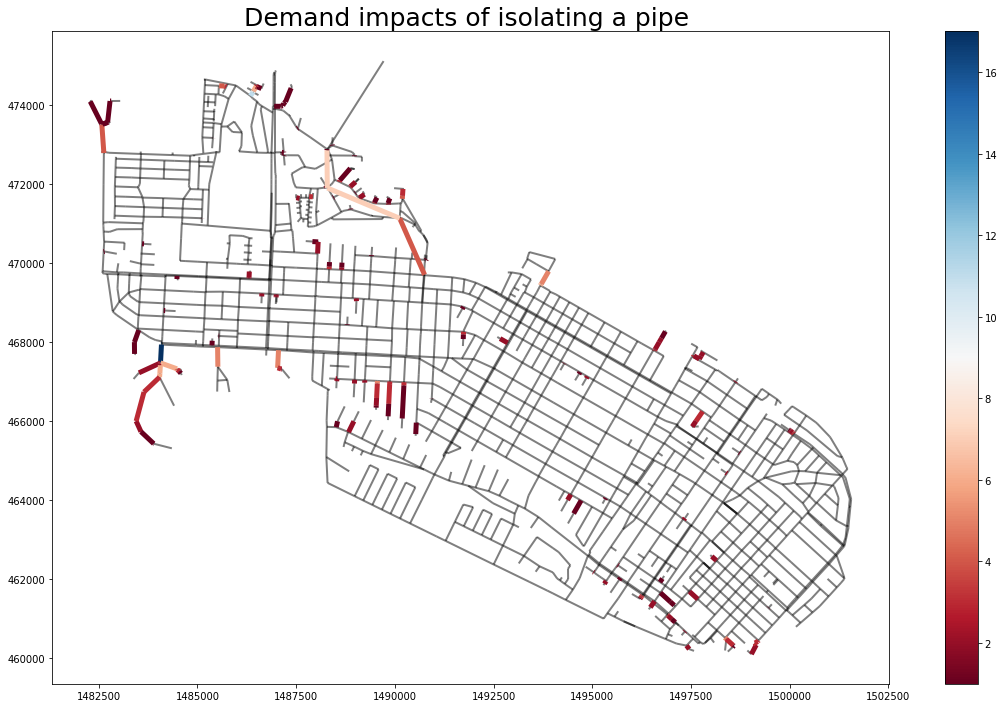

In [120]:
def plot_demand_impacts():
    base = pipe_data
    
    demand = pipe_data[pipe_data['pipe_names'].isin(demand_important_pipes)]
    demand = demand.set_index('pipe_names')
    ser = pd.Series(demand_impact_number, index =demand_important_pipes) 
    demand['impact_number'] = ser


    ax = base.plot(figsize = (20,12),
                         linewidth=2,
                        color = 'black',
                        alpha = 0.5)

    ax = demand.plot(ax= ax,
                         column='impact_number',
                        cmap = 'RdBu',
                        linewidth=5,
                        alpha = 1,
                     legend=True)
    
#     vfail_rate = fail_rates[i]
#     title = f'''Demand Cost for Valve Failure Rate {round(vfail_rate, 2)} '''
#     hig_ax.set_title(title, fontsize=25)
    title = f'''Demand impacts of isolating a pipe '''
    ax.set_title(title, fontsize=25)
    ax.plot()
    
plot_demand_impacts()

In [31]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
pipe_cost = pipe_data.copy()

@interact
def plot_demand_cost(i=(0,len(fail_rates)-1,1)):
    dcost = dcosts[i]/tot_demand*100
    pipe_cost['dcost'] = dcost
    base = pipe_cost[pipe_cost['dcost']<3]
    others = pipe_cost[(pipe_cost['dcost']>3)]

    base_ax = base.plot(figsize = (18,10),
                         linewidth=2,
                        color = 'black',
                        alpha = 0.5)

    hig_ax = others.plot(ax= base_ax,
                         column='dcost',
                        cmap = 'RdBu',
                        linewidth=5,
                        alpha = 1,
                     legend=True)
    
    vfail_rate = fail_rates[i]
    title = f'''Demand Cost for Valve Failure Rate {round(vfail_rate, 2)} '''
    hig_ax.set_title(title, fontsize=25)
    hig_ax.plot()

interactive(children=(IntSlider(value=2, description='i', max=5), Output()), _dom_classes=('widget-interact',)…

In [34]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
pipe_cost = pipe_data.copy()
@interact
def plot_demand_cost_diff(i=(1,len(fail_rates)-1,1)):
    dcost_diff = (dcosts[i]-dcosts[0])/tot_demand*100
    pipe_cost['dcost_diff'] = dcost_diff
    base = pipe_cost[pipe_cost['dcost_diff']<1]
    others = pipe_cost[(pipe_cost['dcost_diff']>1)]

    base_ax = base.plot(figsize = (18,10),
                         linewidth=2,
                        color = 'black',
                        alpha = 0.5)

    hig_ax = others.plot(ax= base_ax,
                         column='dcost_diff',
                        cmap = 'RdBu',
                        linewidth=5,
                        alpha = 1,
                     legend=True)
    
    vfail_rate = fail_rates[i]
    title = f'''Demand Cost Increment for Valve Failure Rate {round(vfail_rate, 2)} '''
    hig_ax.set_title(title, fontsize=25)
    hig_ax.plot()

interactive(children=(IntSlider(value=3, description='i', max=5, min=1), Output()), _dom_classes=('widget-inte…

In [29]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
pipe_cost = pipe_data.copy()

@interact
def plot_pressure_cost(i=(0,len(fail_rates)-1,1)):
    pcost = pcosts[i]
    pipe_cost['pcost'] = pcost
    base = pipe_cost[pipe_cost['pcost']<10]
    others = pipe_cost[(pipe_cost['pcost']>10)]

    base_ax = base.plot(figsize = (18,10),
                         linewidth=2,
                        color = 'black',
                        alpha = 0.5)

    hig_ax = others.plot(ax= base_ax,
                         column='pcost',
                        cmap = 'RdBu',
                        linewidth=5,
                        alpha = 1,
                     legend=True)
    
    vfail_rate = fail_rates[i]
    title = f'''Pressure Cost for Valve Failure Rate {round(vfail_rate, 2)} '''
    hig_ax.set_title(title, fontsize=25)
    hig_ax.plot()

interactive(children=(IntSlider(value=2, description='i', max=5), Output()), _dom_classes=('widget-interact',)…

In [30]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
pipe_cost = pipe_data.copy()
@interact
def plot_pressure_cost_diff(i=(1,len(fail_rates)-1,1)):
    pcost_diff = (pcosts[i]-pcosts[0])
    pipe_cost['pcost_diff'] = pcost_diff
    base = pipe_cost[pipe_cost['pcost_diff']<10]
    others = pipe_cost[(pipe_cost['pcost_diff']>10)]

    base_ax = base.plot(figsize = (18,10),
                         linewidth=2,
                        color = 'black',
                        alpha = 0.5)

    hig_ax = others.plot(ax= base_ax,
                         column='pcost_diff',
                        cmap = 'RdBu',
                        linewidth=5,
                        alpha = 1,
                     legend=True)
    
    vfail_rate = fail_rates[i]
    title = f'''Pressure Cost Increment for Valve Failure Rate {round(vfail_rate, 2)} '''
    hig_ax.set_title(title, fontsize=25)
    hig_ax.plot()

interactive(children=(IntSlider(value=3, description='i', max=5, min=1), Output()), _dom_classes=('widget-inte…